In [10]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from STEM.model import *
from STEM.utils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
scdata = pd.read_csv('./data/mousedata_2020/E2z2/counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('./data/mousedata_2020/E2z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E2z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E2z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E2z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

In [5]:
dp = 1- adata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp

0.5244444444444445

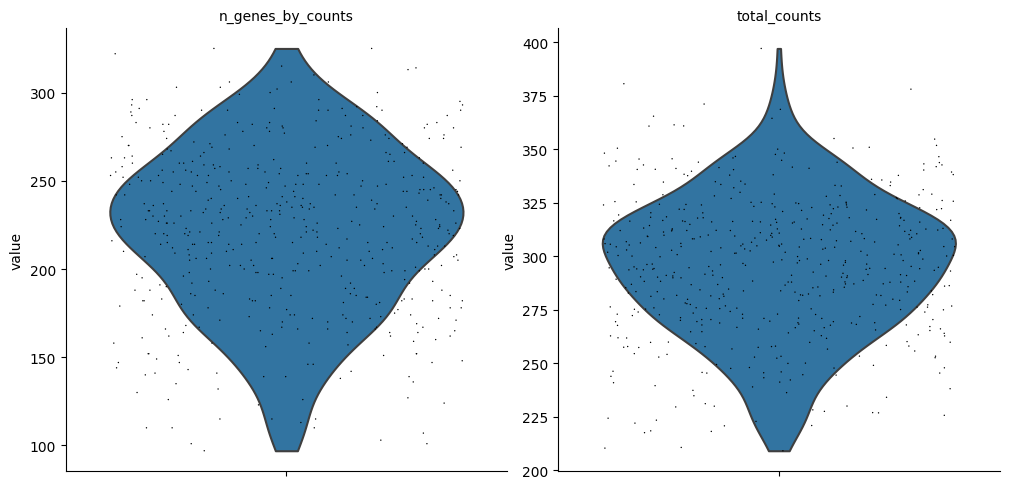

In [6]:
figsize(2,2)
sc.pl.violin(stadata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

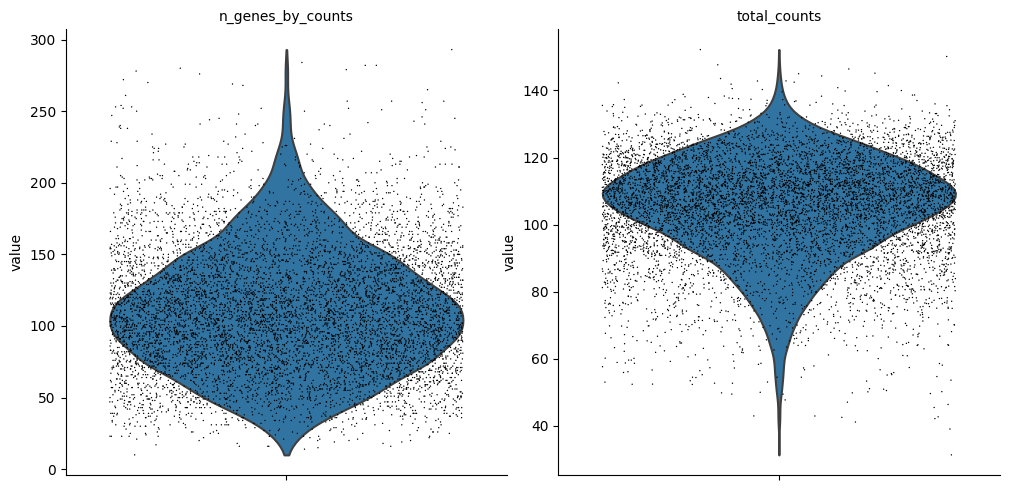

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

In [11]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log/Mouse_E2z2')
setattr(opt, 'n_genes', 351)
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 3)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dp)

In [12]:
%%time
testmodel =  SOmodel(opt)
testmodel.togpu()
# loss_curve = testmodel.train(400,scdataloader,torch.tensor(stdata.values).to(torch.float32),torch.tensor(spcoor.values).to(torch.float32))
loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())

[Train][0] Loss: E 4.279 E_pred 4.223 E_circle 5.074 E_mmd 0.069
[0.002]
[Train][1] Loss: E 5.219 E_pred 5.185 E_circle 5.005 E_mmd 0.042
[0.002]
[Train][2] Loss: E 5.163 E_pred 5.135 E_circle 5.120 E_mmd 0.036
[0.002]
[Train][3] Loss: E 4.964 E_pred 4.921 E_circle 5.235 E_mmd 0.054
[0.002]
[Train][4] Loss: E 4.576 E_pred 4.537 E_circle 5.218 E_mmd 0.049
[0.002]
[Train][5] Loss: E 3.641 E_pred 3.597 E_circle 4.106 E_mmd 0.056
[0.002]
[Train][6] Loss: E 3.789 E_pred 3.753 E_circle 4.648 E_mmd 0.045
[0.002]
[Train][7] Loss: E 3.644 E_pred 3.616 E_circle 3.843 E_mmd 0.036
[0.002]
[Train][8] Loss: E 3.608 E_pred 3.580 E_circle 3.951 E_mmd 0.035
[0.002]
[Train][9] Loss: E 3.591 E_pred 3.568 E_circle 3.845 E_mmd 0.029
[0.002]
[Train][10] Loss: E 3.479 E_pred 3.454 E_circle 3.690 E_mmd 0.031
[0.002]
[Train][11] Loss: E 3.389 E_pred 3.364 E_circle 3.498 E_mmd 0.031
[0.002]
[Train][12] Loss: E 3.355 E_pred 3.330 E_circle 3.385 E_mmd 0.032
[0.002]
[Train][13] Loss: E 3.277 E_pred 3.250 E_circle 

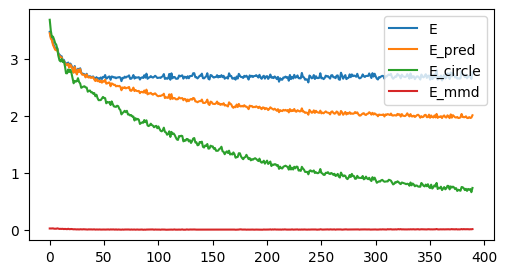

In [13]:
figsize(6,3)
skip=10
N = len(loss_curve['E'])-skip
plt.plot(np.arange(N),loss_curve['E'][skip:],label='E')
plt.plot(np.arange(N),loss_curve['E_pred'][skip:],label='E_pred')
plt.plot(np.arange(N),loss_curve['E_circle'][skip:],label='E_circle')
plt.plot(np.arange(N),loss_curve['E_mmd'][skip:],label='E_mmd')
plt.legend()

In [14]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())

stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())

# netst2sc = F.normalize(torch.exp(scembedding.mm(stembedding.t())),p=1,dim=1).detach().cpu().numpy()
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()

In [15]:
np.save('result/230306_testdp_pure_mmd-E2z2.npy',netst2sc)
np.save('result/230306_testdp_pure_sc2st_mmd-E2z2.npy',netsc2st)
np.save('result/230306_scembbedding-E2z2.npy',scembedding.detach().cpu().numpy())
np.save('result/230306_stembbedding-E2z2.npy',stembedding.detach().cpu().numpy())

In [16]:
testmodel.save()

In [17]:
celltypelist=stgtcelltype.columns[((stgtcelltype>0.1).sum(0)>10)].tolist()
print(celltypelist)

['Anterior somitic tissues', 'Cardiomyocytes', 'Cranial mesoderm', 'Dermomyotome', 'Endothelium', 'Forebrain/Midbrain/Hindbrain', 'Gut tube', 'Haematoendothelial progenitors', 'Mixed mesenchymal mesoderm', 'Neural crest', 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']


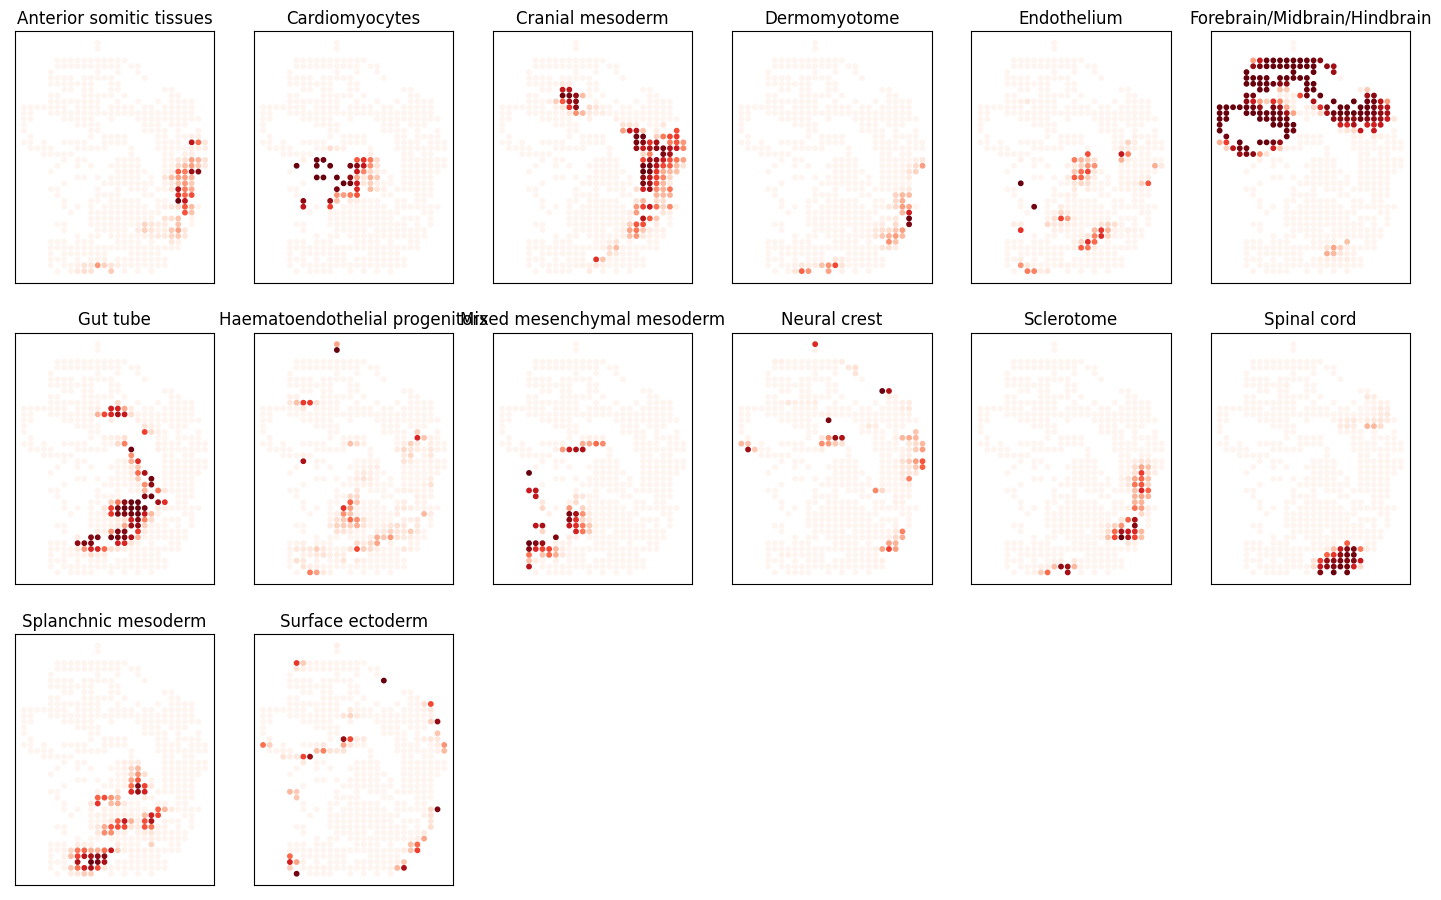

In [18]:
figsize(18,15)
for i in range(len(celltypelist)):
    subplot(4,6,i+1)
    name = celltypelist[i]
    spinalcord = netst2sc[:,scmetadata.celltype_mapped_refined==name].mean(1)    
    plt.scatter(spcoor.coord_x,-spcoor.coord_y,c = spinalcord,cmap='Reds',s=10)
    plt.title(name)
    plt.xticks([])
    plt.yticks([])

In [19]:
scembedding = scembedding.detach().cpu().numpy()

In [20]:
sc2sc = np.matmul(scembedding,scembedding.T)
argmask = np.argsort(-sc2sc,axis=1)

In [21]:
sc_gtcoord = scmetadata[['x_global','y_global']]
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)
true_argmask = np.argsort(true_sc2sc,axis=1)

In [22]:
krg = []
for k in range(1,50):
    k_list = []
    for i in range(argmask.shape[0]):
        k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
    krg.append(np.mean(k_list))

In [23]:
krg

[0.7192272549275551,
 0.9019710220597833,
 1.0390288474089544,
 1.183918548492364,
 1.3504764391071662,
 1.539094113040073,
 1.7502936953400339,
 1.9625375277378931,
 2.191228299177653,
 2.436757603446025,
 2.6929904712178567,
 2.960710090066571,
 3.2468346168907454,
 3.544184832267328,
 3.8432319540529956,
 4.163425140321107,
 4.495496671452813,
 4.833050515598486,
 5.175303485184702,
 5.521863986424749,
 5.882521863986425,
 6.2602793369011875,
 6.6407779663229345,
 7.034068659443937,
 7.427881477613888,
 7.848061610755776,
 8.259626680590001,
 8.685419658008094,
 9.107296697559065,
 9.535439237697428,
 9.984597311055998,
 10.428664665187313,
 10.885524083017883,
 11.34734368881347,
 11.804986294217466,
 12.272549275551494,
 12.743375538441457,
 13.215246051429318,
 13.694556846364705,
 14.176086672758126,
 14.65461428012009,
 15.163686202845582,
 15.653570030022191,
 16.15024148283514,
 16.654353217595613,
 17.15742070225819,
 17.663490405952224,
 18.185354392376976,
 18.704607753556

In [24]:
def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/mappingmtx.values,axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord
adata.obsm['spatialDA'] = all_coord(pd.DataFrame(netsc2st,index=adata.obs_names,columns=stadata.obs_names),spcoor)

# Hyperparamter-research

In [25]:
sc_gtcoord = scmetadata[['x_global','y_global']]
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)
true_argmask = np.argsort(true_sc2sc,axis=1)

In [33]:
from tqdm import tqdm
class setting( object ):
    pass
seed_all(2022)
krgc={}
allloss = {}
for sig in tqdm(np.arange(0,10,1)):
    opt= setting()
    setattr(opt, 'device', 'cuda:0')
    setattr(opt, 'outf', 'log/Mouse_E2z2—sigma-search')
    setattr(opt, 'n_genes', 351)
    setattr(opt, 'no_bn', False)
    setattr(opt, 'lr', 0.002)
    setattr(opt, 'sigma', sig)
    setattr(opt, 'alpha', 0.8)
    setattr(opt, 'verbose', False)
    setattr(opt, 'mmdbatch', 1000)
    setattr(opt, 'dp', dp)

    testmodel = SOmodel(opt)
    testmodel.togpu()
    loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())
    testmodel.modeleval()
    scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
    scembedding = scembedding.detach().cpu().numpy()
    sc2sc = np.matmul(scembedding,scembedding.T)
    argmask = np.argsort(-sc2sc,axis=1)
    krg = []
    for k in range(1,51):
        k_list = []
        for i in range(argmask.shape[0]):
            k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
        krg.append(np.mean(k_list))
        
    testmodel.modeleval()
    scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
    stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
    # netst2sc = F.normalize(torch.exp(scembedding.mm(stembedding.t())),p=1,dim=1).detach().cpu().numpy()
    netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()
    spaotsc_coord = all_coord(pd.DataFrame(netsc2st),spcoor)
    dis_kall = np.sqrt(((sc_gtcoord.values - spaotsc_coord)**2).sum(1))
    print(sig,np.sum(dis_kall),np.mean(dis_kall))
    allloss['sig_'+str(sig)] = loss_curve
    krgc['sig_'+str(sig)] = krg

 10%|█         | 1/10 [00:16<02:27, 16.42s/it]

0 291767.5141217534 38.08478189815342


 20%|██        | 2/10 [00:35<02:23, 17.97s/it]

1 233978.54393917834 30.541514676827873


 30%|███       | 3/10 [00:55<02:12, 18.88s/it]

2 84273.59936643098 11.000339298581252


 40%|████      | 4/10 [01:14<01:53, 18.90s/it]

3 68868.5839581682 8.989503192555567


 50%|█████     | 5/10 [01:33<01:34, 18.90s/it]

4 65404.07809807334 8.537276869608842


 60%|██████    | 6/10 [01:51<01:15, 18.75s/it]

5 65964.332606666 8.610407597789584


 70%|███████   | 7/10 [02:10<00:56, 18.70s/it]

6 68930.1084907117 8.997534067447031


 80%|████████  | 8/10 [02:28<00:37, 18.61s/it]

7 69482.78248836802 9.069675301966846


 90%|█████████ | 9/10 [02:47<00:18, 18.62s/it]

8 70596.73846038387 9.215081381070862


100%|██████████| 10/10 [03:05<00:00, 18.56s/it]

9 73273.77097583031 9.564517814362395


In [34]:
pd.DataFrame(krgc).to_csv('./result/sigma_MouseE2z2.csv')

In [35]:
import pickle
with open('./result/sigma_MouseE2z2.pkl','wb') as f:
    pickle.dump(loss_curve,f)

Text(0, 0.5, 'hit number')

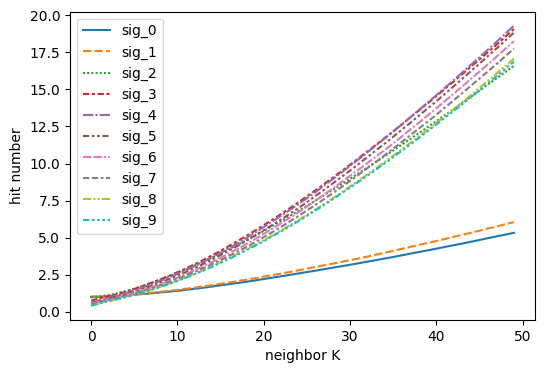

In [36]:
import seaborn as sns
figsize(6,4)
ax = sns.lineplot(data = pd.DataFrame(krgc))
plt.xlabel('neighbor K')
plt.ylabel('hit number')

In [37]:
coord = torch.tensor(spcoor.values).float()

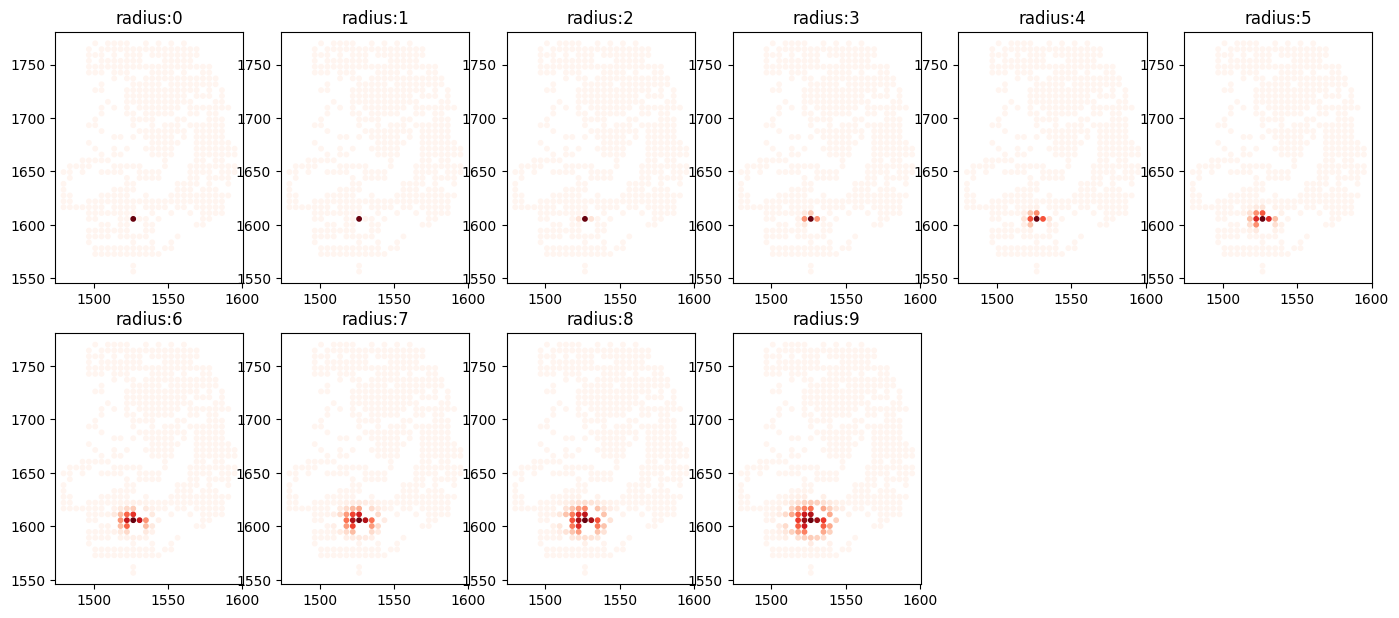

In [38]:
figsize(17,15)
j=1
for sigma in np.arange(0,10,1):
    subplot(4,6,j)
    j+=1
    if sigma==0:
        nettrue = torch.eye(coord.shape[0]).numpy()
    else:
        nettrue = torch.tensor(scipy.spatial.distance.cdist(coord,coord)).to(torch.float32)
        nettrue = torch.exp(-nettrue**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
        nettrue = F.normalize(nettrue,p=1,dim=1).numpy()
    plt.scatter(spcoor.values[:,0],spcoor.values[:,1],c=nettrue[60,:],s=10,cmap='Reds')
    plt.title(f'radius:{sigma}')

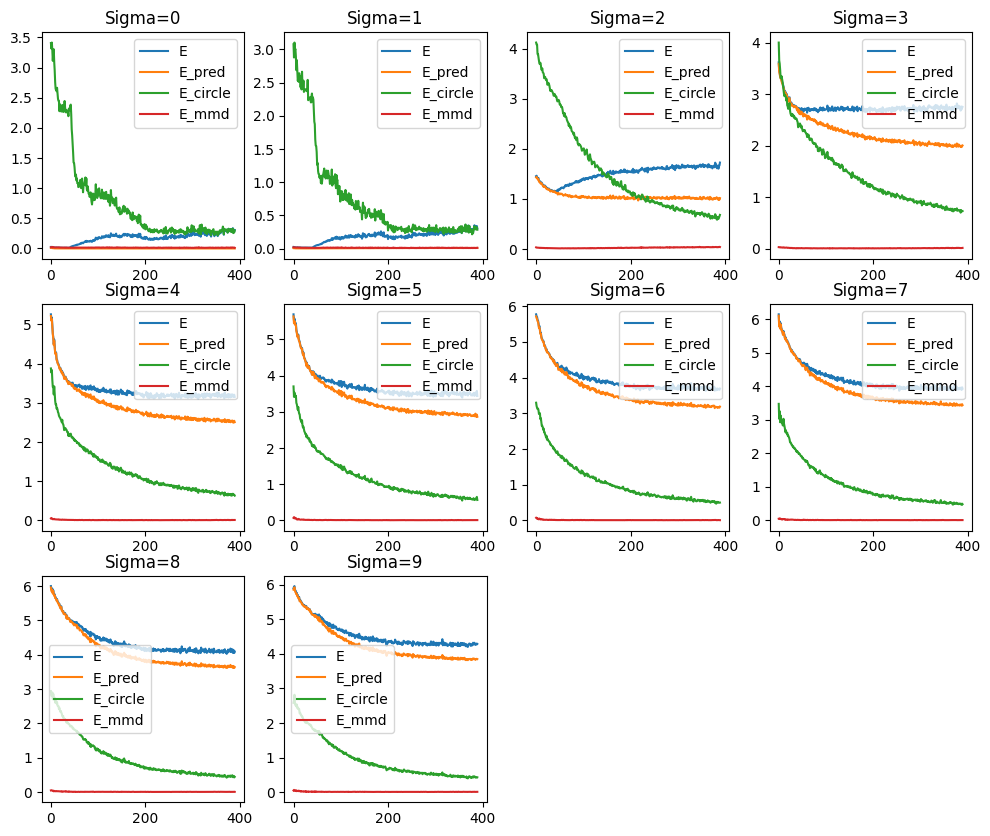

In [46]:
figsize(12,10)
j=1
for sigma in np.arange(0,10,1):
    subplot(3,4,j)
    j+=1
    loss_curve = allloss['sig_'+str(sigma)]
    skip=10
    N = len(loss_curve['E'])-skip
    plt.plot(np.arange(N),loss_curve['E'][skip:],label='E')
    plt.plot(np.arange(N),loss_curve['E_pred'][skip:],label='E_pred')
    plt.plot(np.arange(N),loss_curve['E_circle'][skip:],label='E_circle')
    plt.plot(np.arange(N),loss_curve['E_mmd'][skip:],label='E_mmd')
    plt.title(f'Sigma={sigma}')
    plt.legend()